## Task : **3D Point Cloud Processing & Analysis Project**

# Import Libraries

In [1]:
pip install open3d numpy matplotlib

In [2]:
import os
import numpy as np
import torch
import open3d as o3d
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Link Google Drive (for Google Colab)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Dataset

In [3]:
# Access dataset
dataset_base_dir = '../Stanford3dDataset_v1.2/'

# List directories - each area
areas = [os.path.join(dataset_base_dir, name) for name in os.listdir(dataset_base_dir) if os.path.isdir(os.path.join(dataset_base_dir, name))]
print("Areas found:")
for area in areas:
    print(area)

Areas found:
../Stanford3dDataset_v1.2/Area_1
../Stanford3dDataset_v1.2/Area_2
../Stanford3dDataset_v1.2/Area_3
../Stanford3dDataset_v1.2/Area_4
../Stanford3dDataset_v1.2/Area_5
../Stanford3dDataset_v1.2/Area_6


# Select Area

In [4]:
# Select Area 1 to exploration
selected_area_path = '../Stanford3dDataset_v1.2/Area_1'

# List contents
point_cloud_files = []
for dirpath, _, filenames in os.walk(selected_area_path):
    for filename in filenames:
        if filename.endswith('.txt'):
            point_cloud_files.append(os.path.join(dirpath, filename))

# Found point clouds
print("Found point cloud files in Area 1:")
for file in point_cloud_files:
    print(file)

Found point cloud files in Area 1:
../Stanford3dDataset_v1.2/Area_1\Area_1_alignmentAngle.txt
../Stanford3dDataset_v1.2/Area_1\conferenceRoom_1\conferenceRoom_1.txt
../Stanford3dDataset_v1.2/Area_1\conferenceRoom_1\Annotations\beam_1.txt
../Stanford3dDataset_v1.2/Area_1\conferenceRoom_1\Annotations\board_1.txt
../Stanford3dDataset_v1.2/Area_1\conferenceRoom_1\Annotations\board_2.txt
../Stanford3dDataset_v1.2/Area_1\conferenceRoom_1\Annotations\board_3.txt
../Stanford3dDataset_v1.2/Area_1\conferenceRoom_1\Annotations\bookcase_1.txt
../Stanford3dDataset_v1.2/Area_1\conferenceRoom_1\Annotations\ceiling_1.txt
../Stanford3dDataset_v1.2/Area_1\conferenceRoom_1\Annotations\chair_1.txt
../Stanford3dDataset_v1.2/Area_1\conferenceRoom_1\Annotations\chair_10.txt
../Stanford3dDataset_v1.2/Area_1\conferenceRoom_1\Annotations\chair_11.txt
../Stanford3dDataset_v1.2/Area_1\conferenceRoom_1\Annotations\chair_12.txt
../Stanford3dDataset_v1.2/Area_1\conferenceRoom_1\Annotations\chair_13.txt
../Stanford3d

In [20]:
office_file_path = '../Stanford3dDataset_v1.2/Area_1/office_1/office_1.txt'

# Load point cloud file (format: X Y Z R G B)
office_data = np.loadtxt(office_file_path, delimiter=' ')

# Create Open3D point cloud object
office_1_pcd = o3d.geometry.PointCloud()
office_1_pcd.points = o3d.utility.Vector3dVector(office_data[:, 0:3])  # XYZ coordinates
if office_data.shape[1] >= 6:
    office_1_pcd.colors = o3d.utility.Vector3dVector(office_data[:, 3:6] / 255.0)  # Normalize RGB values

# Visualize
o3d.visualization.draw_geometries([office_1_pcd])

In [19]:
# Save as .ply file
output_directory = 'Data'
output_filename = 'office_1.ply'
output_file_path = os.path.join(output_directory, output_filename)

# Ensure directory exists
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Save point cloud as a .ply file
o3d.io.write_point_cloud(output_file_path, office_1_pcd)

print(f'Saved point cloud to: {output_file_path}')

Saved point cloud to: Data\office_1.ply


# Data preprocessing

### Voxel Downsampling

In [21]:
# Define voxel size
voxel_size = 0.05
downsampled_office_pcd = office_1_pcd.voxel_down_sample(voxel_size)

# Visualize original & downsampled side by side for comparison
o3d.visualization.draw_geometries([office_1_pcd], window_name="Original Point Cloud")
o3d.visualization.draw_geometries([downsampled_office_pcd], window_name="Downsampled Point Cloud")

### Statistical Outlier Removal

In [22]:
# Define parameters
nb_neighbors = 20
std_ratio = 2.0

# Apply statistical outlier removal
cl, ind = downsampled_office_pcd.remove_statistical_outlier(nb_neighbors=nb_neighbors, std_ratio=std_ratio)
inlier_cloud = downsampled_office_pcd.select_by_index(ind)
outlier_cloud = downsampled_office_pcd.select_by_index(ind, invert=True)

# Visualize inliers & outliers
o3d.visualization.draw_geometries([inlier_cloud], window_name='Inliers')
o3d.visualization.draw_geometries([outlier_cloud], window_name='Outliers')

### Radius Outlier Removal

In [9]:
# Parameters
radius = 0.05
min_neighbors = 2

# Apply radius outlier removal
inlier_cloud, ind = inlier_cloud.remove_radius_outlier(radius=radius, nb_points=min_neighbors)

# Visualize point cloud after radius outlier removal
o3d.visualization.draw_geometries([inlier_cloud], window_name="Inliers after Radius Outlier Removal")

In [10]:
# # Save as .ply file
output_file = 'Data/inlier_cloud_after_radius_outlier_removal.ply'

# Save inlier_cloud as a .ply file
o3d.io.write_point_cloud(output_file, inlier_cloud)

print(f'Point cloud saved to {output_file}')

Point cloud saved to Data/inlier_cloud_after_radius_outlier_removal.ply


### 3D Harris Corner detection

In [23]:
from scipy.spatial import KDTree

def harris_response(points, neighbors, k=0.04):
    harris_values = np.zeros(points.shape[0])
    for idx, point in enumerate(points):
        local_points = points[neighbors[idx]]
        if len(local_points) < 3:
            continue
        cov_matrix = np.cov(local_points, rowvar=False)
        eigvals = np.linalg.eigvalsh(cov_matrix)
        harris_values[idx] = eigvals[0] * eigvals[1] - k * (eigvals[0] + eigvals[1]) ** 2
    return harris_values

def harris_3d_detection(point_cloud, radius=0.05, k=0.04, threshold=1e-8):
    points = np.asarray(point_cloud.points)
    tree = KDTree(points)
    neighbors = tree.query_ball_point(points, radius)

    harris_values = harris_response(points, neighbors, k)

    # Print stats of Harris values (for debugging)
    print(f"Harris response values: min={harris_values.min()}, max={harris_values.max()}, mean={harris_values.mean()}, std={harris_values.std()}")

    interest_points = np.where(harris_values > threshold)[0]

    return interest_points, harris_values

def visualize_corners(point_cloud, corners):
    # Paint points gray
    point_cloud.paint_uniform_color([0.5, 0.5, 0.5])

    # Highlight corners in red
    colors = np.asarray(point_cloud.colors)
    colors[corners] = [1, 0, 0]
    point_cloud.colors = o3d.utility.Vector3dVector(colors)
    o3d.visualization.draw_geometries([point_cloud], window_name="Harris 3D Corners")

# Load point cloud
input_ply_file = "Data/inlier_cloud_after_radius_outlier_removal.ply"
point_cloud = o3d.io.read_point_cloud(input_ply_file)

# Ensure the point cloud has colors
if not point_cloud.has_colors():
    point_cloud.paint_uniform_color([0.5, 0.5, 0.5])

# Apply Harris 3D Corner Detection
corners, harris_values = harris_3d_detection(point_cloud, radius=0.05, k=0.04, threshold=1e-8)

# Print number of detected corners(for debugging)
print(f"Number of detected corners: {len(corners)}")

# Visualize detected corners
visualize_corners(point_cloud, corners)

# Save point cloud with corners highlighted
output_ply_file = "Data/harris_corners_output.ply"
o3d.io.write_point_cloud(output_ply_file, point_cloud)

Harris response values: min=-5.789114315384709e-08, max=2.8900600168762094e-07, mean=-2.938177452616978e-09, std=1.307591219277332e-08
Number of detected corners: 1803


True

# Segmentation

## Ground Plane Segmentation

In [25]:
# Define height threshold
height_threshold = 1.0

# Filter points based on Z coordinate (height)
points = np.asarray(inlier_cloud.points)
colors = np.asarray(inlier_cloud.colors)
filtered_points = points[points[:, 2] < height_threshold]
filtered_colors = colors[points[:, 2] < height_threshold]

# New point cloud with filtered points
filtered_cloud = o3d.geometry.PointCloud()
filtered_cloud.points = o3d.utility.Vector3dVector(filtered_points)
filtered_cloud.colors = o3d.utility.Vector3dVector(filtered_colors)

# Plane segmentation using RANSAC on filtered point cloud
plane_model, inliers = filtered_cloud.segment_plane(distance_threshold=0.01,
                                                    ransac_n=3,
                                                    num_iterations=2000)

# Extract inliers & outliers
ground_plane = filtered_cloud.select_by_index(inliers)
non_ground = inlier_cloud.select_by_index(inliers, invert=True)

# Color ground plane blue & non-ground points gray
ground_plane.paint_uniform_color([0, 0, 1])
non_ground.paint_uniform_color([0.5, 0.5, 0.5])

# Visualize segmented ground plane and the rest
o3d.visualization.draw_geometries([ground_plane, non_ground], window_name="Ground Plane Segmentation")

## Initial Region Growing Segmentation

In [26]:
def region_growing_segmentation(pcd, min_cluster_size=560, distance_threshold=0.0076):
    points = np.asarray(pcd.points)
    labels = np.full(len(points), -1, dtype=int)
    current_label = 0

    for idx in range(len(points)):
        if labels[idx] == -1:
            queue = [idx]
            labels[idx] = current_label
            while queue:
                current_point = queue.pop()
                distances = np.linalg.norm(points - points[current_point], axis=1)
                neighbors = np.where(distances < distance_threshold)[0]
                for neighbor in neighbors:
                    if labels[neighbor] == -1:
                        labels[neighbor] = current_label
                        queue.append(neighbor)
            current_label += 1

    return labels

# Load point cloud
input_ply_file = "Data/inlier_cloud_after_radius_outlier_removal.ply"
point_cloud = o3d.io.read_point_cloud(input_ply_file)

# Region growing segmentation on non-ground points
labels = region_growing_segmentation(point_cloud, min_cluster_size=200, distance_threshold=0.05)

# Print number of clusters
num_clusters = len(np.unique(labels)) - 1  # Excluding noise label (-1)
print(f'Number of clusters identified: {num_clusters}')

# Assign colors to clusters
colors = np.zeros((len(point_cloud.points), 3))
unique_labels = np.unique(labels)
for label in unique_labels:
    if label == -1:
        color = [0, 0, 0]  # Black = noise
    else:
        color = np.random.rand(3)
    colors[labels == label] = color

# Create new point cloud with colored clusters
clustered_cloud = o3d.geometry.PointCloud()
clustered_cloud.points = o3d.utility.Vector3dVector(np.asarray(point_cloud.points))
clustered_cloud.colors = o3d.utility.Vector3dVector(colors)

# Visualize clustered point cloud
o3d.visualization.draw_geometries([clustered_cloud], window_name="Further Adjusted Region Growing Segmentation")

# Save clustered point cloud
output_clustered_file = "Data/further_adjusted_region_growing_clustered_output.ply"
o3d.io.write_point_cloud(output_clustered_file, clustered_cloud)
print(f'Clustered point cloud saved to {output_clustered_file}')

Number of clusters identified: 1218
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
Clustered point cloud saved to Data/further_adjusted_region_growing_clustered_output.ply


##  Refined Segmentation: Large Planes and Smaller Objects

In [27]:
def compute_normals(pcd, radius=0.1, max_nn=30):
    pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius, max_nn=max_nn))
    pcd.normalize_normals()
    return pcd

def segment_planes(pcd, distance_threshold=0.05, ransac_n=3, num_iterations=1000, min_points=500):
    planes = []
    plane_labels = np.zeros(len(pcd.points), dtype=int) - 1
    current_label = 0
    remaining_pcd = pcd

    while len(remaining_pcd.points) > min_points:
        plane_model, inliers = remaining_pcd.segment_plane(distance_threshold=distance_threshold,
                                                           ransac_n=ransac_n,
                                                           num_iterations=num_iterations)
        if len(inliers) < min_points:
            break

        plane = remaining_pcd.select_by_index(inliers)
        planes.append(plane)
        plane_labels[inliers] = current_label
        current_label += 1
        remaining_pcd = remaining_pcd.select_by_index(inliers, invert=True)

    return plane_labels, planes, remaining_pcd

def segment_objects(pcd, min_cluster_size=100, distance_threshold=0.05):
    points = np.asarray(pcd.points)
    labels = np.full(len(points), -1, dtype=int)
    current_label = 0

    for idx in range(len(points)):
        if labels[idx] == -1:
            queue = [idx]
            labels[idx] = current_label
            while queue:
                current_point = queue.pop()
                distances = np.linalg.norm(points - points[current_point], axis=1)
                neighbors = np.where(distances < distance_threshold)[0]
                for neighbor in neighbors:
                    if labels[neighbor] == -1:
                        labels[neighbor] = current_label
                        queue.append(neighbor)
            current_label += 1

    # Remove small clusters
    unique_labels, counts = np.unique(labels, return_counts=True)
    for label, count in zip(unique_labels, counts):
        if count < min_cluster_size:
            labels[labels == label] = -1

    return labels

# Load point cloud
input_ply_file = "Data/further_adjusted_region_growing_clustered_output.ply"
point_cloud = o3d.io.read_point_cloud(input_ply_file)

# Compute normals for point cloud
point_cloud = compute_normals(point_cloud)

# Segment large planes (walls, ceiling, floor)
plane_labels, planes, remaining_pcd = segment_planes(point_cloud, distance_threshold=0.05, min_points=500)

# Color large planes uniformly
colors = np.zeros((len(point_cloud.points), 3))
for i, plane in enumerate(planes):
    color = np.random.rand(3)
    plane_points = np.asarray(plane.points)
    for j, point in enumerate(point_cloud.points):
        if np.any(np.all(point == plane_points, axis=1)):
            colors[j] = color

# Segment & color smaller objects
object_labels = segment_objects(remaining_pcd, min_cluster_size=100, distance_threshold=0.05)
unique_object_labels = np.unique(object_labels)
for label in unique_object_labels:
    if label == -1:
        continue
    color = np.random.rand(3)
    for i, point in enumerate(remaining_pcd.points):
        if object_labels[i] == label:
            colors[np.where(np.all(np.isclose(point_cloud.points, point), axis=1))[0][0]] = color

# Create new point cloud with colored clusters
clustered_cloud = o3d.geometry.PointCloud()
clustered_cloud.points = o3d.utility.Vector3dVector(np.asarray(point_cloud.points))
clustered_cloud.colors = o3d.utility.Vector3dVector(colors)

# Visualize clustered point cloud
try:
    o3d.visualization.draw_geometries([clustered_cloud], window_name="Segmented and Colored Point Cloud")
except Exception as e:
    print(f'Visualization failed: {e}')

# Save clustered point cloud
output_clustered_file = "Data/segmented_and_colored_output.ply"
o3d.io.write_point_cloud(output_clustered_file, clustered_cloud)
print(f'Clustered point cloud saved to {output_clustered_file}')

# Load the previously saved clustered point cloud
final_pcd = o3d.io.read_point_cloud(output_clustered_file)
final_points = np.asarray(final_pcd.points)
final_colors = np.asarray(final_pcd.colors)

# Remove large planes from the point cloud
plane_indices = set()
for plane in planes:
    plane_points = np.asarray(plane.points)
    for point in plane_points:
        plane_indices.add(tuple(point))

non_plane_indices = [i for i, point in enumerate(final_points) if tuple(point) not in plane_indices]

remaining_points = final_points[non_plane_indices]
remaining_colors = final_colors[non_plane_indices]

remaining_pcd = o3d.geometry.PointCloud()
remaining_pcd.points = o3d.utility.Vector3dVector(remaining_points)
remaining_pcd.colors = o3d.utility.Vector3dVector(remaining_colors)

# Segment & visualize individual objects
remaining_object_labels = segment_objects(remaining_pcd, min_cluster_size=50, distance_threshold=0.02)

for label in np.unique(remaining_object_labels):
    if label == -1:
        continue
    object_points = np.asarray(remaining_pcd.points)[remaining_object_labels == label]
    object_pcd = o3d.geometry.PointCloud()
    object_pcd.points = o3d.utility.Vector3dVector(object_points)
    object_pcd.paint_uniform_color(np.random.rand(3))

    # Visualize each object individually
    o3d.visualization.draw_geometries([object_pcd], window_name=f"Object {label}")

Clustered point cloud saved to Data/segmented_and_colored_output.ply


# Counting Task

In [30]:
from sklearn.cluster import DBSCAN

# Load previously saved clustered point cloud
output_clustered_file = "Data/segmented_and_colored_output.ply"
final_pcd = o3d.io.read_point_cloud(output_clustered_file)
final_points = np.asarray(final_pcd.points)
final_colors = np.asarray(final_pcd.colors)

# Tolerance for color comparison
color_tolerance = 1e-5

# Unique colors & corresponding points
unique_colors = np.unique(final_colors, axis=0)
object_count = len(unique_colors)

# Dictionary to hold points
color_to_points = {tuple(color): [] for color in unique_colors}

# Assign points to corresponding color key
for point, color in zip(final_points, final_colors):
    for unique_color in unique_colors:
        if np.all(np.abs(color - unique_color) < color_tolerance):
            color_to_points[tuple(unique_color)].append(point)
            break

# Output count of unique colors (objects)
print(f"Number of unique objects identified by color: {object_count}")

# Optionally, visualize the first unique color object (small objects)
for color, points in color_to_points.items():
    object_pcd = o3d.geometry.PointCloud()
    object_pcd.points = o3d.utility.Vector3dVector(np.array(points))
    object_pcd.paint_uniform_color(np.array(color))

    o3d.visualization.draw_geometries([object_pcd], window_name=f"Object with color {color}")
    break

Number of unique objects identified by color: 13


# PointNet (Google Colab)

In [17]:
# Clone PointNet repo
!git clone https://github.com/yanx27/Pointnet_Pointnet2_pytorch.git
%cd Pointnet_Pointnet2_pytorch

Cloning into 'Pointnet_Pointnet2_pytorch'...
remote: Enumerating objects: 842, done.
remote: Total 842 (delta 0), reused 0 (delta 0), pack-reused 842
Receiving objects: 100% (842/842), 68.77 MiB | 38.29 MiB/s, done.
Resolving deltas: 100% (485/485), done.
/content/Pointnet_Pointnet2_pytorch


## Prepare Dataset

In [18]:
import shutil
import os

# Define source & destination directories
source_dir = '/content/drive/MyDrive/Stanford3dDataset/Stanford3dDataset_v1.2/'
destination_dir = '/content/data/s3dis/Stanford3dDataset_v1.2_Aligned_Version/'

# Create the directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Copy dataset
shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)

print("Dataset copied successfully.")

Dataset copied successfully.


In [20]:
# List files in destination
!ls /content/drive/MyDrive/Stanford3dDataset/Stanford3dDataset_v1.2/

Area_1	Area_2	Area_3	Area_4	Area_5	Area_6


In [22]:
# Ensure data_utils directory is added
sys.path.append('/content/Pointnet_Pointnet2_pytorch/data_utils')
# Import the collect_indoor3d_data function from the script
from collect_indoor3d_data import collect_point_label

# Function to run the data collection process
def run_data_collection():
    BASE_DIR = '/content/Pointnet_Pointnet2_pytorch/data_utils'
    ROOT_DIR = os.path.dirname(BASE_DIR)
    DATA_PATH = '/content/data/s3dis/Stanford3dDataset_v1.2_Aligned_Version'

    anno_paths = [line.rstrip() for line in open(os.path.join(BASE_DIR, 'meta/anno_paths.txt'))]
    anno_paths = [os.path.join(DATA_PATH, p) for p in anno_paths]

    output_folder = os.path.join(ROOT_DIR, 'data/stanford_indoor3d')
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)

    # Process each annotation path
    for anno_path in anno_paths:
        print(anno_path)
        try:
            elements = anno_path.split('/')
            out_filename = elements[-3] + '_' + elements[-2] + '.npy'  # Area_1_hallway_1.npy
            collect_point_label(anno_path, os.path.join(output_folder, out_filename), 'numpy')
        except Exception as e:
            print(anno_path, 'ERROR!!', str(e))

# Run the data collection process
run_data_collection()

print("Data collection and preprocessing complete.")

Streaming output truncated to the last 5000 lines.
/content/data/s3dis/Stanford3dDataset_v1.2_Aligned_Version/Area_4/office_12/Annotations/clutter_4.txt
/content/data/s3dis/Stanford3dDataset_v1.2_Aligned_Version/Area_4/office_12/Annotations/clutter_17.txt
/content/data/s3dis/Stanford3dDataset_v1.2_Aligned_Version/Area_4/office_12/Annotations/clutter_8.txt
/content/data/s3dis/Stanford3dDataset_v1.2_Aligned_Version/Area_4/office_12/Annotations/table_4.txt
/content/data/s3dis/Stanford3dDataset_v1.2_Aligned_Version/Area_4/office_12/Annotations/door_1.txt
/content/data/s3dis/Stanford3dDataset_v1.2_Aligned_Version/Area_4/office_12/Annotations/wall_2.txt
/content/data/s3dis/Stanford3dDataset_v1.2_Aligned_Version/Area_4/office_12/Annotations/chair_1.txt
/content/data/s3dis/Stanford3dDataset_v1.2_Aligned_Version/Area_4/office_12/Annotations/clutter_19.txt
/content/data/s3dis/Stanford3dDataset_v1.2_Aligned_Version/Area_4/office_12/Annotations/table_2.txt
/content/data/s3dis/Stanford3dDataset_v1.

## Train Model

In [23]:
import torch
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [52]:
!python train_semseg.py --model pointnet2_sem_seg --test_area 1 --log_dir pointnet2_sem_seg

PARAMETER ...
Namespace(model='pointnet2_sem_seg', batch_size=32, epoch=10, learning_rate=0.001, gpu='0', optimizer='Adam', log_dir='pointnet2_sem_seg', decay_rate=0.0001, npoint=4096, step_size=10, lr_decay=0.7, test_area=1)
start loading training data ...
100% 227/227 [01:54<00:00,  1.98it/s]
[1.1329876 1.185257  1.        2.9039977 2.4738085 2.2785742 1.8102316
 2.044515  1.9801975 4.0123453 1.6112692 2.918203  1.3936403]
Totally 55648 samples in train set.
start loading test data ...
100% 44/44 [00:39<00:00,  1.12it/s]
[1.1128895 1.2110636 1.        1.7531534 2.0668857 1.9792584 1.7240337
 1.9195656 2.171323  4.071482  1.8625687 2.4284418 1.3038002]
Totally 10751 samples in test set.
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive wor

In [55]:
!python test_semseg.py --log_dir pointnet2_sem_seg --test_area 1 --visual

PARAMETER ...
Namespace(batch_size=32, gpu='0', num_point=4096, log_dir='pointnet2_sem_seg', visual=True, test_area=1, num_votes=3)
The number of test data is: 44
---- EVALUATION WHOLE SCENE----
Inference [1/44] Area_1_office_15 ...
100% 3/3 [00:29<00:00,  9.94s/it]
[0.98033815 0.96925127 0.95070441 0.         0.         0.
 0.86416546 0.93758407 0.93612762 0.         0.         0.
 0.63101063]
Mean IoU of Area_1_office_15: 0.8956
----------------------------
Inference [2/44] Area_1_hallway_5 ...
100% 3/3 [00:28<00:00,  9.49s/it]
[0.95710989 0.98032096 0.92165816 0.         0.         0.
 0.91896711 0.         0.         0.         0.         0.
 0.        ]
Mean IoU of Area_1_hallway_5: 0.7556
----------------------------
Inference [3/44] Area_1_WC_1 ...
100% 3/3 [01:46<00:00, 35.36s/it]
[0.92731713 0.98308332 0.92020934 0.         0.         0.
 0.90707494 0.         0.         0.         0.         0.
 0.87220319]
Mean IoU of Area_1_WC_1: 0.9220
----------------------------
Inferenc

In [56]:
!zip -r visualizations.zip /content/Pointnet_Pointnet2_pytorch/log/sem_seg/pointnet2_sem_seg/visual

  adding: content/Pointnet_Pointnet2_pytorch/log/sem_seg/pointnet2_sem_seg/visual/ (stored 0%)
  adding: content/Pointnet_Pointnet2_pytorch/log/sem_seg/pointnet2_sem_seg/visual/Area_1_office_14_gt.obj (deflated 85%)
  adding: content/Pointnet_Pointnet2_pytorch/log/sem_seg/pointnet2_sem_seg/visual/Area_1_office_7_pred.obj (deflated 85%)
  adding: content/Pointnet_Pointnet2_pytorch/log/sem_seg/pointnet2_sem_seg/visual/Area_1_office_26_pred.obj (deflated 85%)
  adding: content/Pointnet_Pointnet2_pytorch/log/sem_seg/pointnet2_sem_seg/visual/Area_1_hallway_5_gt.obj (deflated 85%)
  adding: content/Pointnet_Pointnet2_pytorch/log/sem_seg/pointnet2_sem_seg/visual/Area_1_office_12.txt (deflated 98%)
  adding: content/Pointnet_Pointnet2_pytorch/log/sem_seg/pointnet2_sem_seg/visual/Area_1_office_15_gt.obj (deflated 86%)
  adding: content/Pointnet_Pointnet2_pytorch/log/sem_seg/pointnet2_sem_seg/visual/Area_1_hallway_1_gt.obj (deflated 86%)
  adding: content/Pointnet_Pointnet2_pytorch/log/sem_seg/p

In [57]:
# Download the ZIP file
from google.colab import files
files.download('/content/Pointnet_Pointnet2_pytorch/visualizations.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

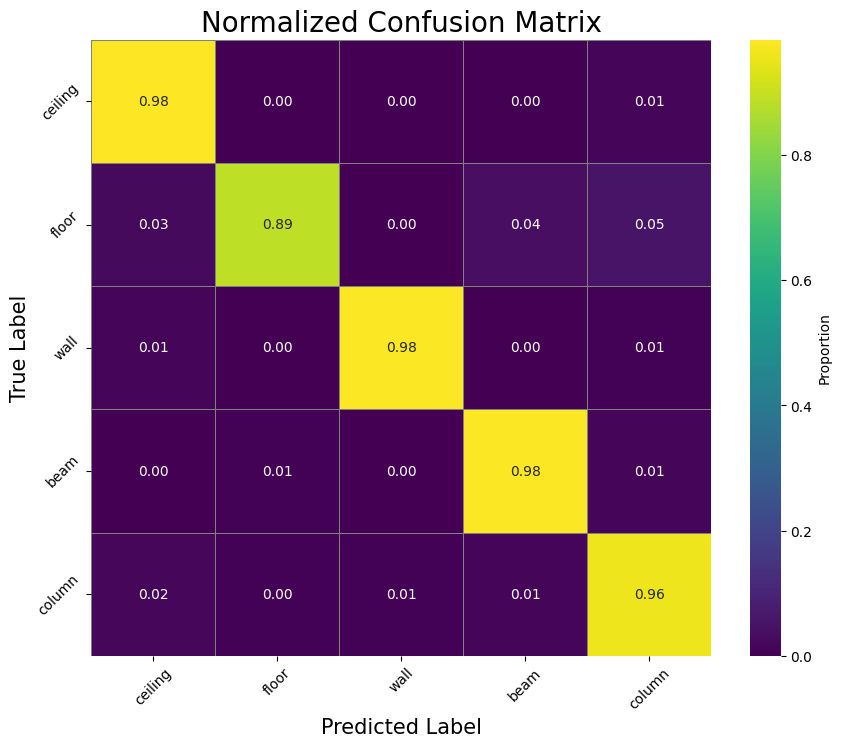

In [65]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to read .obj file and extract labels
def read_obj_labels(file_path):
    labels = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith('v'):
                parts = line.strip().split()
                label = int(parts[-1])  # Assuming the label is the last part
                labels.append(label)
    return labels

# Paths to the specific prediction and ground truth .obj files
pred_file_path = '/content/Pointnet_Pointnet2_pytorch/log/sem_seg/pointnet2_sem_seg/visual/Area_1_office_1_pred.obj'
gt_file_path = '/content/Pointnet_Pointnet2_pytorch/log/sem_seg/pointnet2_sem_seg/visual/Area_1_office_1_gt.obj'

# Read the labels from the files
pred_labels = read_obj_labels(pred_file_path)
gt_labels = read_obj_labels(gt_file_path)

# Define the class names
class_names = ['ceiling', 'floor', 'wall', 'beam', 'column', 'window', 'door', 'table', 'chair', 'sofa', 'bookcase',
               'board', 'clutter']

# Compute confusion matrix
cm = confusion_matrix(gt_labels, pred_labels)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Identify non-zero rows and columns
nonzero_indices = np.where(cm.sum(axis=1) + cm.sum(axis=0) > 0)[0]

# Reduce the matrix to the non-zero rows and columns
cm_reduced = cm_normalized[nonzero_indices, :][:, nonzero_indices]

# Define class names (if applicable)
class_names_reduced = [class_names[i] for i in nonzero_indices]

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm_reduced, annot=True, fmt='.2f', cmap='viridis', xticklabels=class_names_reduced, yticklabels=class_names_reduced, cbar_kws={'label': 'Proportion'}, linewidths=0.5, linecolor='gray')

# Add axis labels and title
ax.set_title('Normalized Confusion Matrix', fontsize=20)
ax.set_xlabel('Predicted Label', fontsize=15)
ax.set_ylabel('True Label', fontsize=15)

# Rotate the tick labels for better readability
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Show the plot
plt.show()

In [66]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Function to read .obj file and extract labels
def read_obj_labels(file_path):
    labels = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith('v'):
                parts = line.strip().split()
                label = int(parts[-1])  # Assuming the label is the last part
                labels.append(label)
    return labels

# Paths to the specific prediction and ground truth .obj files
pred_file_path = '/content/Pointnet_Pointnet2_pytorch/log/sem_seg/pointnet2_sem_seg/visual/Area_1_office_1_pred.obj'
gt_file_path = '/content/Pointnet_Pointnet2_pytorch/log/sem_seg/pointnet2_sem_seg/visual/Area_1_office_1_gt.obj'

# Read the labels from the files
pred_labels = read_obj_labels(pred_file_path)
gt_labels = read_obj_labels(gt_file_path)

# Define the class names
class_names = ['ceiling', 'floor', 'wall', 'beam', 'column', 'window', 'door', 'table', 'chair', 'sofa', 'bookcase',
               'board', 'clutter']

# Compute precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(gt_labels, pred_labels, labels=list(range(len(class_names))), zero_division=0)

# Compute overall accuracy
accuracy = accuracy_score(gt_labels, pred_labels)

# Compute mean precision, recall, and F1-score
mean_precision = np.mean(precision)
mean_recall = np.mean(recall)
mean_f1 = np.mean(f1)

# Print the report
print("Class-wise Precision, Recall, and F1-score:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: Precision = {precision[i]:.2f}, Recall = {recall[i]:.2f}, F1-score = {f1[i]:.2f}")

print(f"Overall Accuracy: {accuracy:.2f}")
print(f"Mean Precision: {mean_precision:.2f}")
print(f"Mean Recall: {mean_recall:.2f}")
print(f"Mean F1-score: {mean_f1:.2f}")

Class-wise Precision, Recall, and F1-score:
ceiling: Precision = 0.95, Recall = 0.98, F1-score = 0.97
floor: Precision = 0.00, Recall = 0.00, F1-score = 0.00
wall: Precision = 0.00, Recall = 0.00, F1-score = 0.00
beam: Precision = 0.00, Recall = 0.00, F1-score = 0.00
column: Precision = 0.00, Recall = 0.00, F1-score = 0.00
window: Precision = 0.00, Recall = 0.00, F1-score = 0.00
door: Precision = 0.00, Recall = 0.00, F1-score = 0.00
table: Precision = 0.00, Recall = 0.00, F1-score = 0.00
chair: Precision = 0.00, Recall = 0.00, F1-score = 0.00
sofa: Precision = 0.00, Recall = 0.00, F1-score = 0.00
bookcase: Precision = 0.00, Recall = 0.00, F1-score = 0.00
board: Precision = 0.00, Recall = 0.00, F1-score = 0.00
clutter: Precision = 0.00, Recall = 0.00, F1-score = 0.00
Overall Accuracy: 0.96
Mean Precision: 0.07
Mean Recall: 0.08
Mean F1-score: 0.07


# Test Pipeline Features on Kitti

## Wrapper for UI

In [31]:
import tkinter as tk
from tkinter import filedialog, messagebox, ttk
import open3d as o3d
import numpy as np

# Function to load KITTI bin file
def load_kitti_bin(file_path):
    point_cloud = np.fromfile(file_path, dtype=np.float32).reshape(-1, 4)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(point_cloud[:, :3])
    return pcd

# Voxel Downsampling
def voxel_downsampling(point_cloud, voxel_size=0.05):
    return point_cloud.voxel_down_sample(voxel_size)

# Statistical Outlier Removal
def statistical_outlier_removal(point_cloud, nb_neighbors=20, std_ratio=2.0):
    cl, ind = point_cloud.remove_statistical_outlier(nb_neighbors=nb_neighbors, std_ratio=std_ratio)
    inlier_cloud = point_cloud.select_by_index(ind)
    return inlier_cloud

# Radius Outlier Removal
def radius_outlier_removal(point_cloud, radius=0.05, min_neighbors=2):
    inlier_cloud, ind = point_cloud.remove_radius_outlier(radius=radius, nb_points=min_neighbors)
    return inlier_cloud

# Ground Plane Segmentation
def ground_plane_segmentation(point_cloud, height_threshold=1.0, distance_threshold=0.01):
    points = np.asarray(point_cloud.points)
    colors = np.asarray(point_cloud.colors) if point_cloud.has_colors() else None
    filtered_points = points[points[:, 2] < height_threshold]
    filtered_colors = colors[points[:, 2] < height_threshold] if colors is not None else None

    filtered_cloud = o3d.geometry.PointCloud()
    filtered_cloud.points = o3d.utility.Vector3dVector(filtered_points)
    if filtered_colors is not None:
        filtered_cloud.colors = o3d.utility.Vector3dVector(filtered_colors)

    plane_model, inliers = filtered_cloud.segment_plane(distance_threshold=distance_threshold, ransac_n=3, num_iterations=2000)

    ground_plane = filtered_cloud.select_by_index(inliers)
    non_ground = point_cloud.select_by_index(inliers, invert=True)

    ground_plane.paint_uniform_color([0, 0, 1])
    non_ground.paint_uniform_color([0.5, 0.5, 0.5])

    return ground_plane, non_ground

# Function to color clusters
def color_clusters(point_cloud, labels):
    colors = np.zeros((len(point_cloud.points), 3))
    unique_labels = np.unique(labels)
    for label in unique_labels:
        if label == -1:
            color = [0, 0, 0]  # Black = noise
        else:
            color = np.random.rand(3)
        colors[labels == label] = color

    clustered_cloud = o3d.geometry.PointCloud()
    clustered_cloud.points = point_cloud.points
    clustered_cloud.colors = o3d.utility.Vector3dVector(colors)
    return clustered_cloud

# Function to segment objects
def segment_objects(pcd, min_cluster_size=100, distance_threshold=0.05):
    points = np.asarray(pcd.points)
    labels = np.full(len(points), -1, dtype=int)
    current_label = 0

    # KDTree for efficient neighbor search
    kdtree = o3d.geometry.KDTreeFlann(pcd)

    for idx in range(len(points)):
        if labels[idx] == -1:
            queue = [idx]
            labels[idx] = current_label
            while queue:
                current_point = queue.pop()
                [_, idxs, _] = kdtree.search_radius_vector_3d(points[current_point], distance_threshold)
                for neighbor in idxs:
                    if labels[neighbor] == -1:
                        labels[neighbor] = current_label
                        queue.append(neighbor)
            current_label += 1

    # Remove small clusters
    unique_labels, counts = np.unique(labels, return_counts=True)
    for label, count in zip(unique_labels, counts):
        if count < min_cluster_size:
            labels[labels == label] = -1

    return labels

# Function to handle file selection
def select_file():
    file_path = filedialog.askopenfilename(filetypes=[("KITTI Bin Files", "*.bin")])
    if file_path:
        file_label.config(text=file_path)
        global point_cloud
        point_cloud = load_kitti_bin(file_path)
        messagebox.showinfo("Info", "File loaded successfully!")

# Function to run the selected process
def run_process():
    process = process_combo.get()
    if not point_cloud:
        messagebox.showerror("Error", "Please upload a file first.")
        return

    if process == 'Voxel Downsampling':
        result = voxel_downsampling(point_cloud)
    elif process == 'Statistical Outlier Removal':
        result = statistical_outlier_removal(point_cloud)
    elif process == 'Radius Outlier Removal':
        result = radius_outlier_removal(point_cloud)
    elif process == 'Ground Plane Segmentation':
        ground, non_ground = ground_plane_segmentation(point_cloud)
        o3d.visualization.draw_geometries([ground, non_ground], window_name="Ground Plane Segmentation")
        return
    elif process == 'Cluster Objects':
        labels = segment_objects(point_cloud, min_cluster_size=100, distance_threshold=0.05)
        result = color_clusters(point_cloud, labels)
    else:
        messagebox.showerror("Error", "Unknown process selected.")
        return

    o3d.visualization.draw_geometries([result], window_name=process)

# Initialize the Tkinter application
root = tk.Tk()
root.title("Point Cloud Processing")

# Global variable to store the point cloud
point_cloud = None

# Create UI components
upload_btn = tk.Button(root, text="Upload KITTI Bin File", command=select_file)
upload_btn.pack(pady=10)

file_label = tk.Label(root, text="No file selected")
file_label.pack(pady=5)

process_combo = ttk.Combobox(root, values=[
    'Voxel Downsampling',
    'Statistical Outlier Removal',
    'Radius Outlier Removal',
    'Ground Plane Segmentation',
    'Cluster Objects'
])
process_combo.set('Select Process')
process_combo.pack(pady=10)

run_btn = tk.Button(root, text="Run", command=run_process)
run_btn.pack(pady=20)

# Run the application
root.mainloop()